In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    #%pip install bitsandbytes

    !git clone https://github.com/MartinKirkegaardDK/KDS_MI.git

    if not has_changed_dir:
        os.chdir('KDS_MI')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True

In [2]:
from drivers import preprocessing
from drivers import probe_confidence_intervals

## preprocessing

In [ ]:
preprocessing.run()

## probe_confidence_intervals

Load model
Load data
Extract activations


  5%|▍         | 6/130 [00:22<07:54,  3.83s/it]


Initiate classes
Bootstrap


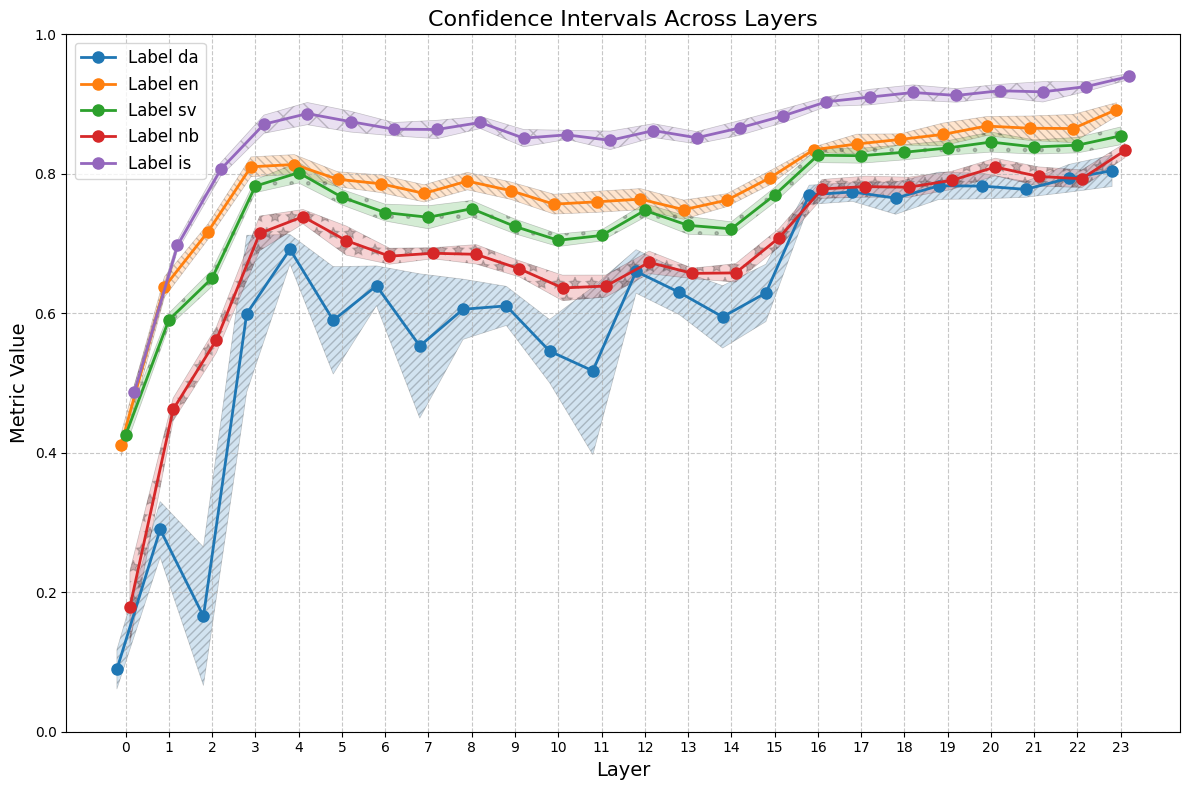

Initiate classes
Bootstrap


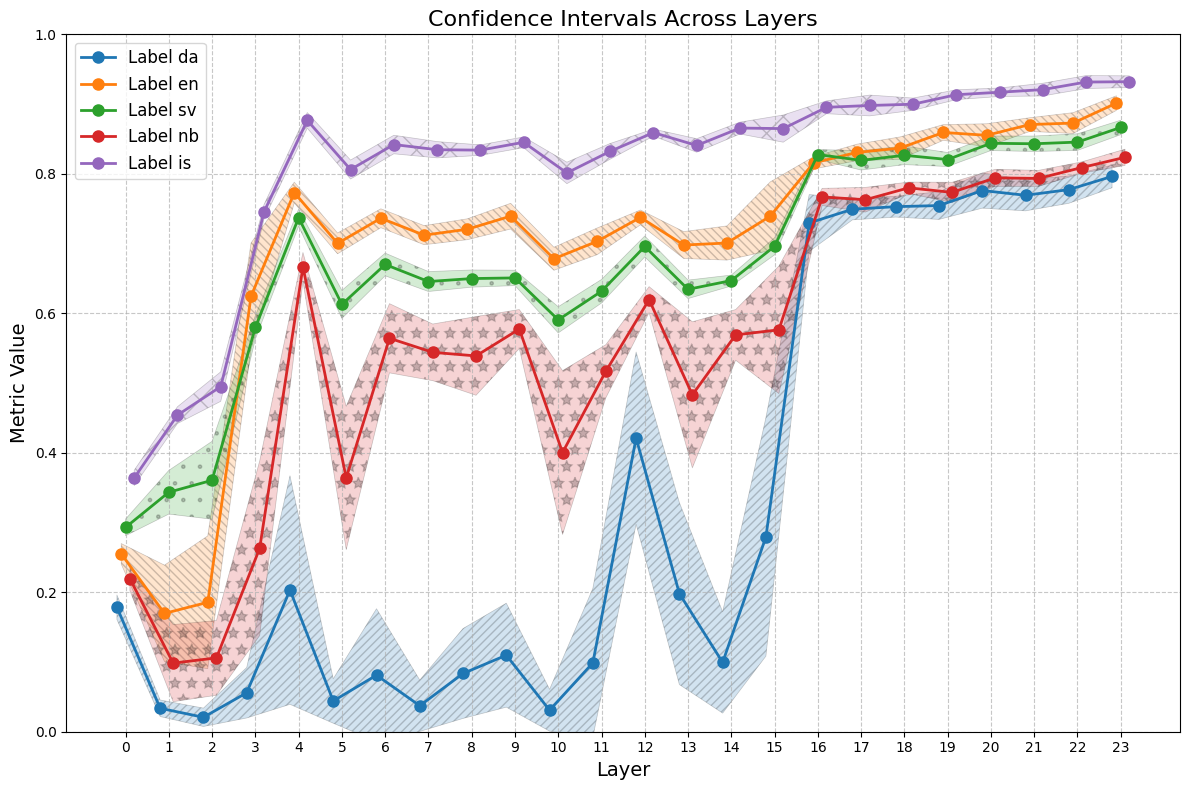

Initiate classes
Bootstrap


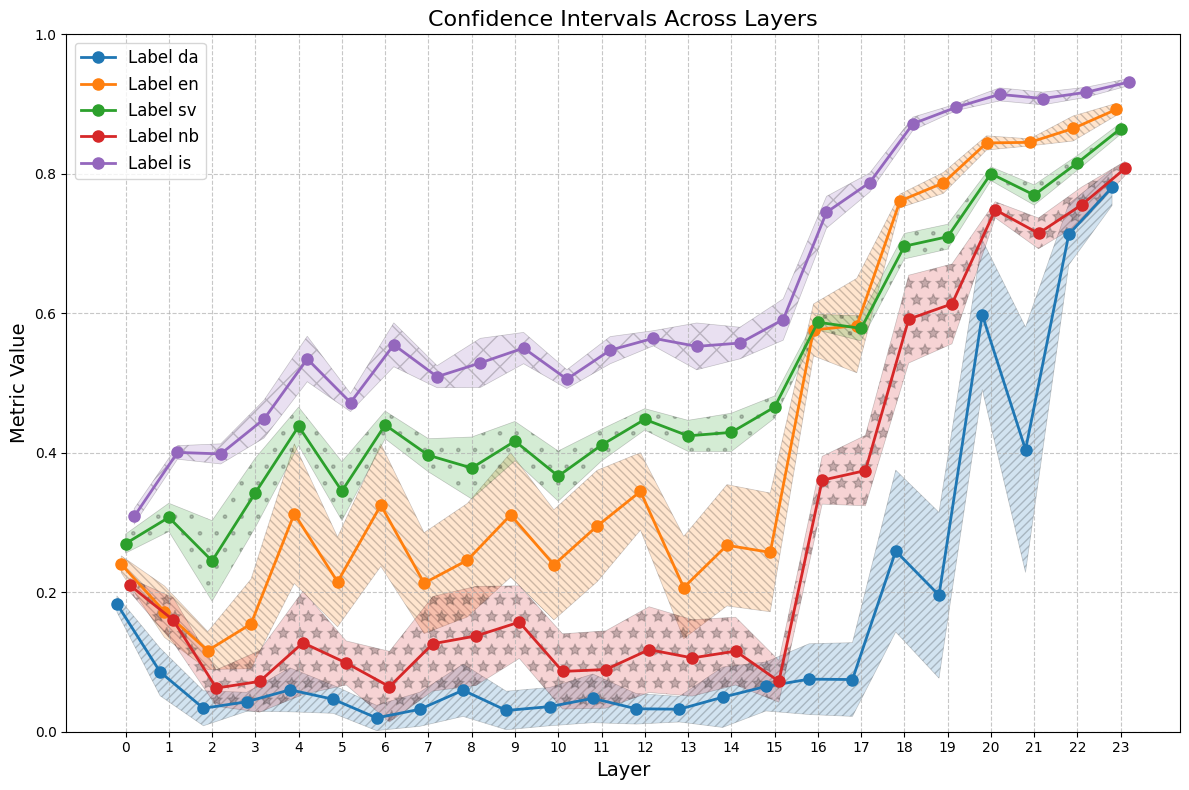

Initiate classes
Bootstrap


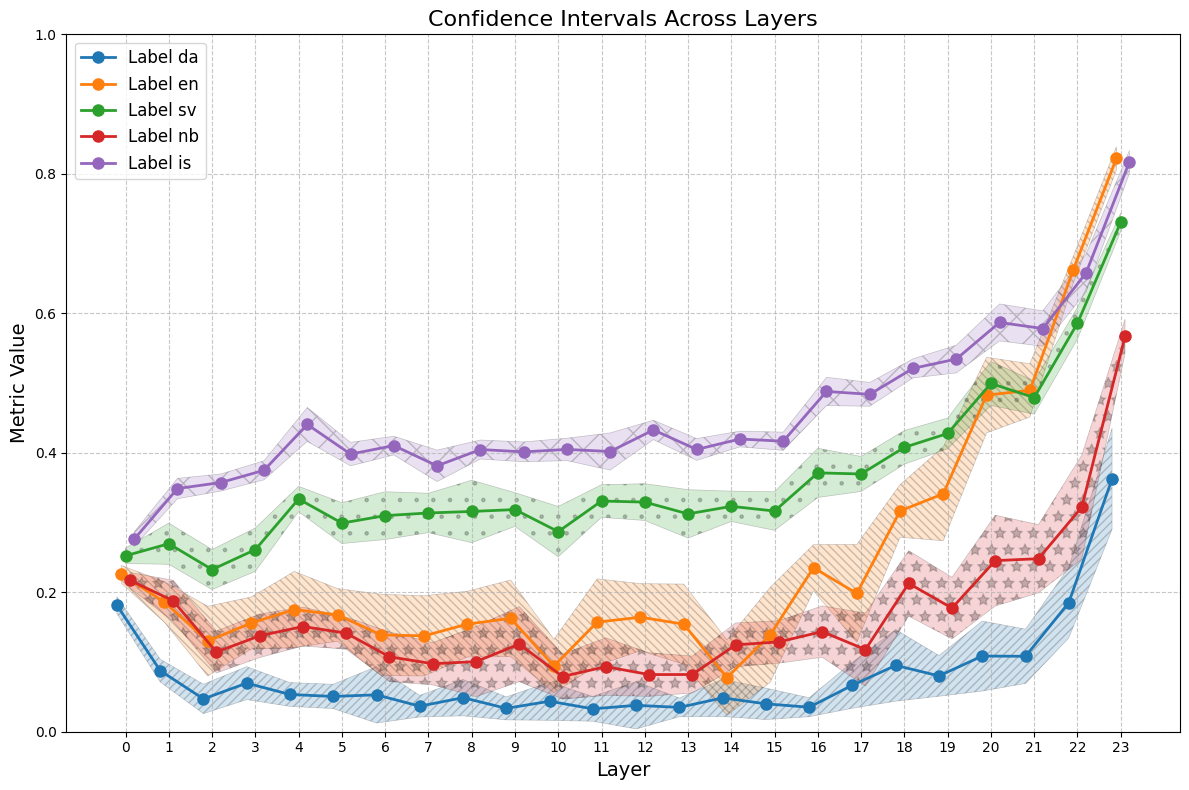

Initiate classes
Bootstrap


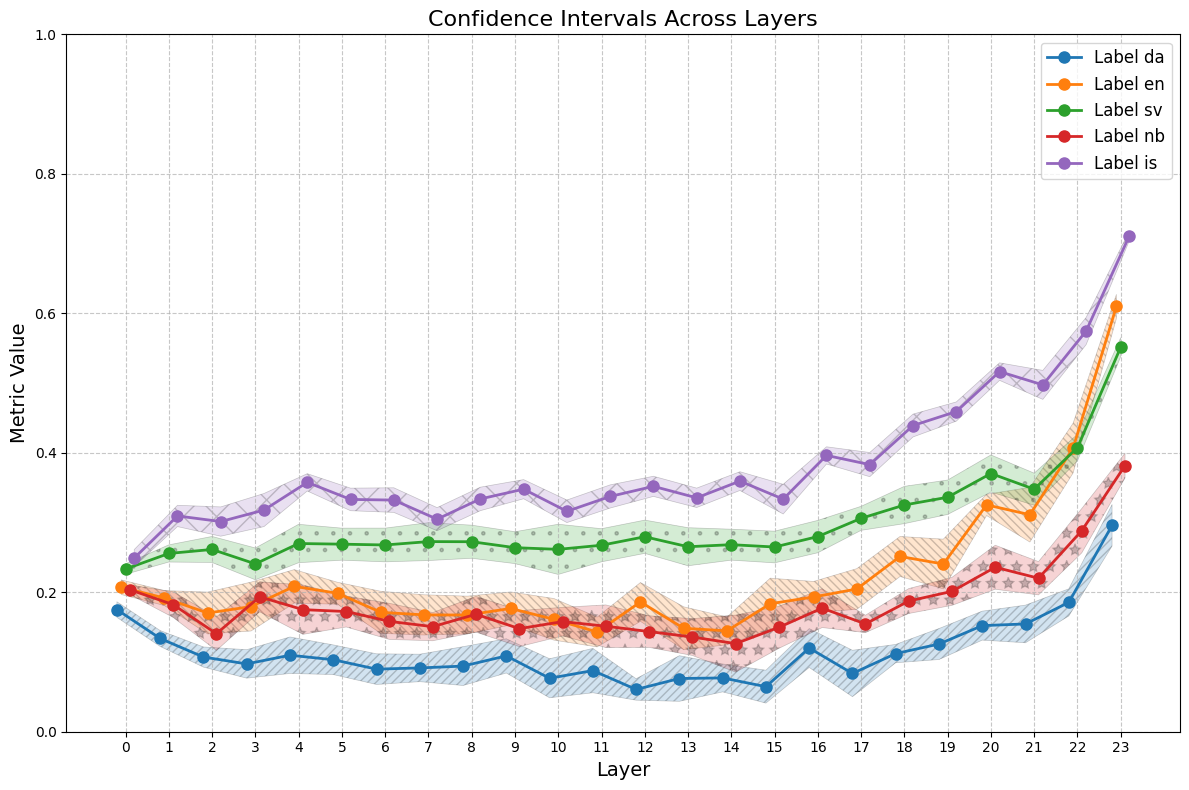

Initiate classes
Bootstrap


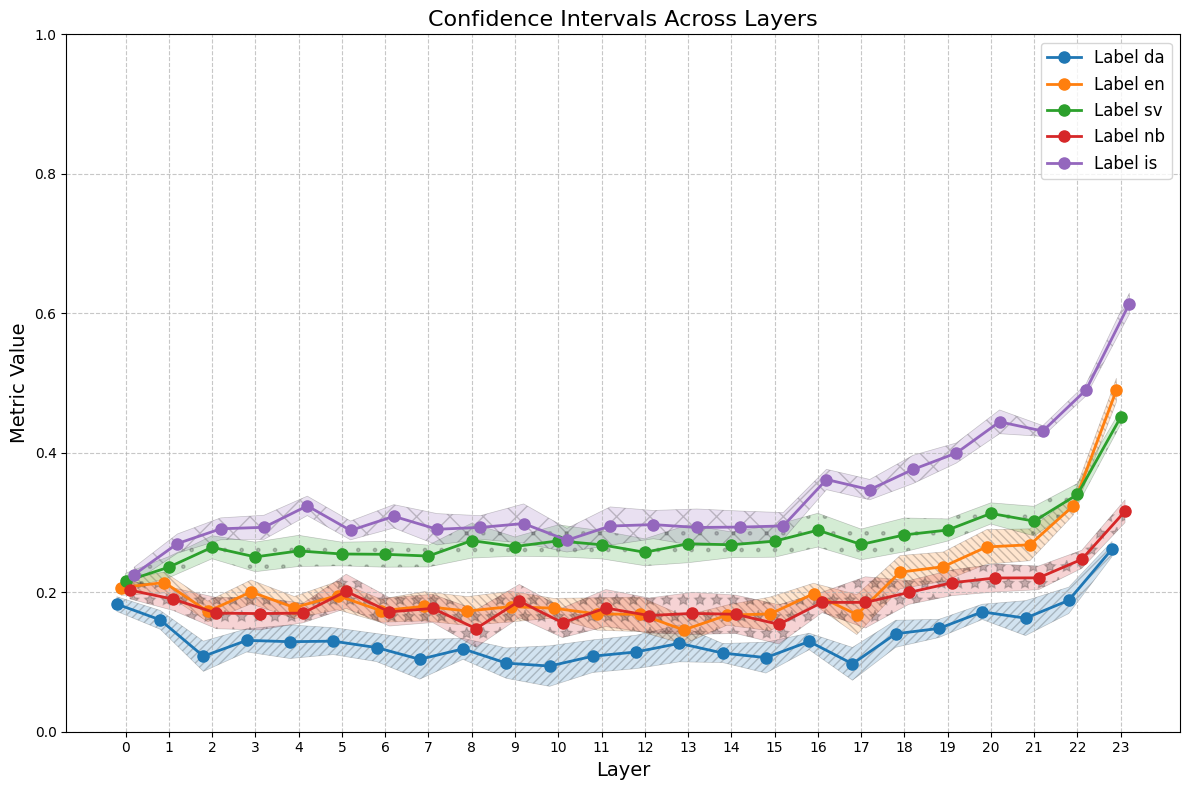

In [3]:
probe_confidence_intervals.run()